## 页面版式分析并绘图的函数

In [68]:
# 初始化环境变量
from dotenv import load_dotenv
load_dotenv()
# 初始化 PDF文件路径
# file_path = "../../90-文档_Data/山西文旅/云冈石窟-ch.pdf"
file_path = "../../90-文档_Data/test/xiaomi14.pdf"

#### 1. 渲染指定PDF页面并绘制段落分类框 函数

In [69]:
import fitz  # PyMuPDF库，用于处理PDF文件
import matplotlib.patches as patches  # 用于在图像上绘制多边形
import matplotlib.pyplot as plt  # Matplotlib库，用于绘图
from PIL import Image  # 用于图像处理

def render_pdf_page(file_path, doc_list, page_number):
    """
    渲染指定PDF页面并绘制段落分类框。

    参数：
    - file_path: str，PDF文件路径。
    - doc_list: list，包含段落信息的文档列表，每个元素是一个字典，包含段落元数据。
    - page_number: int，要渲染的页面号（从1开始计数）。
    """
    # 打开PDF文件并加载指定页面
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    segments = [doc.metadata for doc in doc_list if doc.metadata.get("page_number") == page_number]

    # 将PDF页面渲染为位图图像
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # 创建绘图环境
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(pil_image)

    # 定义类别颜色映射
    category_to_color = {"Title": "orchid", "Image": "forestgreen", "Table": "tomato"}
    categories = set()

    # 绘制段落标注框
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height) for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(scaled_points, linewidth=1, edgecolor=box_color, facecolor="none")
        ax.add_patch(rect)

    # 添加图例
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category, color in category_to_color.items():
        if category in categories:
            legend_handles.append(patches.Patch(color=color, label=category))
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
plt.show()

#### 2. 用Unstructured解析文档

In [70]:
from langchain_unstructured import UnstructuredLoader
import pprint
import os

loader = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
    partition_via_api=True,  # 通过API调用Unstructured
    coordinates=True,  # 返回元素位置坐标
    api_key=os.getenv("UNSTRUCTURED_API_KEY"),
    # infer_table_structure=True,  # 推断表格结构
    # extract_images=True,  # 提取图像
    # image_format="png",  # 图像格式
    # include_metadata=True  # 包含元数据
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

for doc in docs[:5]:
    pprint.pprint(doc.model_dump())

INFO: HTTP Request: GET https://api.unstructuredapp.io/general/docs "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"


{'id': None,
 'metadata': {'category': 'NarrativeText',
              'coordinates': {'layout_height': 2339,
                              'layout_width': 1654,
                              'points': [[250.0, 276.31024169921875],
                                         [250.0, 864.3222222222224],
                                         [1415.3211669921875,
                                          864.3222222222224],
                                         [1415.3211669921875,
                                          276.31024169921875]],
                              'system': 'PixelSpace'},
              'element_id': 'a50f8f7181228a973f90c30226595e3f',
              'filename': 'xiaomi14.pdf',
              'filetype': 'application/pdf',
              'languages': ['eng'],
              'page_number': 1,
              'source': '../../90-文档_Data/test/xiaomi14.pdf'},
 'page_content': '随着科技的飞速发展，手机摄影早已不再是简单的记 录，而是成为展现个性、捕捉美好瞬间的艺术工具。 在众多影像旗舰中，小米 '
                 '14 Ultra 以其卓越的影

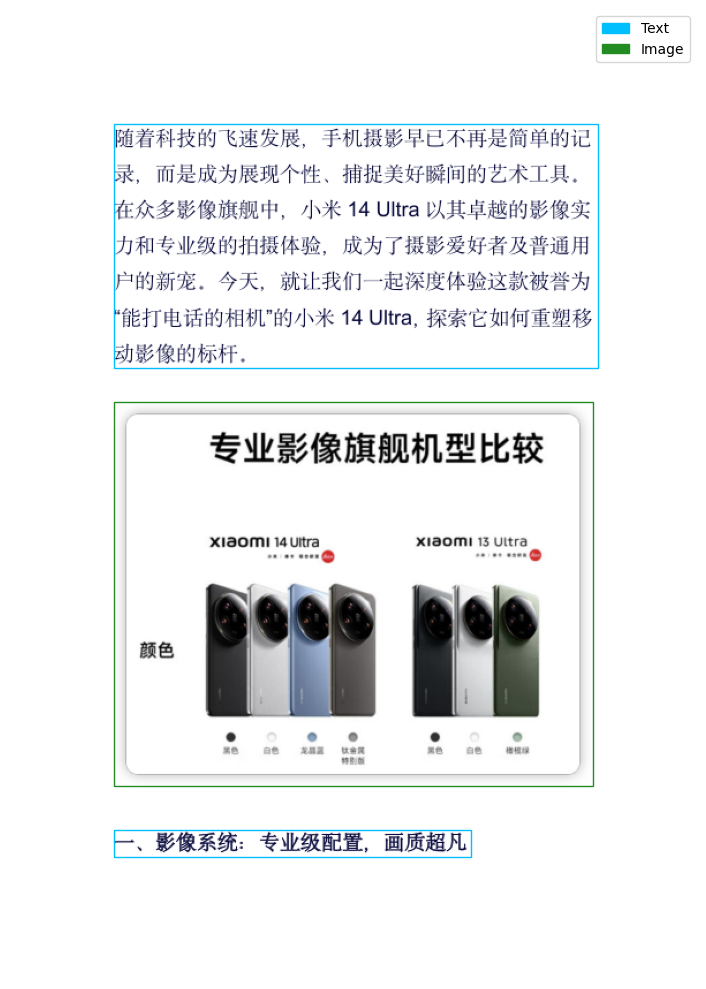

In [71]:
render_pdf_page(file_path, docs, 1)

#### 3. 仅筛选第一页的 Doc

In [72]:
page_number = 1
page_docs = [doc for doc in docs if doc.metadata.get("page_number") == page_number]

# 遍历并打印每个 Doc 的详细信息
for i, doc in enumerate(page_docs, 1):
    print(f"Doc {i}:")
    print(f"  内容: {doc.page_content}")
    print(f"  分类: {doc.metadata.get('category')}")
    print(f"  ID: {doc.metadata.get('element_id')}")
    print(f"  Parent ID: {doc.metadata.get('parent_id')}")
    print(f"  位置: {doc.metadata.get('position')}")
    print(f"  坐标: {doc.metadata.get('coordinates')}")
    print("=" * 50)

Doc 1:
  内容: 随着科技的飞速发展，手机摄影早已不再是简单的记 录，而是成为展现个性、捕捉美好瞬间的艺术工具。 在众多影像旗舰中，小米 14 Ultra 以其卓越的影像实 力和专业级的拍摄体验，成为了摄影爱好者及普通用 户的新宠。今天，就让我们一起深度体验这款被誉为 “能打电话的相机”的小米 14 Ultra，探索它如何重塑移 动影像的标杆。
  分类: NarrativeText
  ID: a50f8f7181228a973f90c30226595e3f
  Parent ID: None
  位置: None
  坐标: {'points': [[250.0, 276.31024169921875], [250.0, 864.3222222222224], [1415.3211669921875, 864.3222222222224], [1415.3211669921875, 276.31024169921875]], 'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339}
Doc 2:
  内容: Q BE o E B ® ] en ¢l lwoeix eln vl oelix I R EY =
  分类: Image
  ID: 05dfcbce127639fa6c291a0dade3fe68
  Parent ID: None
  位置: None
  坐标: {'points': [[250.0, 947.3333333333331], [250.0, 1873.3333333333333], [1402.6666666666665, 1873.3333333333333], [1402.6666666666665, 947.3333333333331]], 'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339}
Doc 3:
  内容: 一、影像系统：专业级配置，画质超凡
  分类: NarrativeText
  ID: 47edf85d06e6981973e5ca4ea5864424
  Parent ID: None
  位置: None
  坐标: {'points':

#### 4. 解析文档并列出所有Title

In [73]:
titles = [doc.page_content for doc in docs if doc.metadata.get("category") == "Title"]

# 输出Title
print("本PDF中的 Title 包括：")
for i, title in enumerate(titles, 1):
    print(f"{i}. {title}")

本PDF中的 Title 包括：
1. LPDDR5X + UFS 4.0
2. R S RRRS
3. S
4. W INK BB L T 80W KEREL R
5. 二、AI 算法：超越人眼，深入人心
6. 四、性能与设计：顶配加持，专业范十足
7. 总结：小米 14 Ultra，一部真正能打电话的相机
